<a href="https://colab.research.google.com/github/dewaalaw/dsprojects/blob/main/search-term-analysis/src/coffee_search_trend_part_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Development Environment

In [25]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

from pandas.tseries.offsets import MonthEnd
from itertools import product
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Read Training Data

In [16]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
csv_path = '/gdrive/MyDrive/SearchTermAnalysis/data/monthly_coffee_search_nam_2014-2018.csv'
df = pd.read_csv(csv_path)
df.head()

,Month,Coffee
0,2014-08,36
1,2014-09,0
2,2014-10,30
3,2014-11,25
4,2014-12,20


# Data Exploration

In [6]:
# Examine Column Data Types
df.dtypes

Month     object
Coffee     int64
dtype: object

In [9]:
# Convert Month object to date-time, adding last day of month as datestamp
df['Month'] = pd.to_datetime(df['Month']) + MonthEnd(1)
df.dtypes

Month     datetime64[ns]
Coffee             int64
dtype: object

In [8]:
# Examine new labels
df.head()

,Month,Coffee
0,2014-08-31,36
1,2014-09-30,0
2,2014-10-31,30
3,2014-11-30,25
4,2014-12-31,20


In [10]:
df.tail()

,Month,Coffee
102,2023-03-31,48
103,2023-04-30,47
104,2023-05-31,49
105,2023-06-30,61
106,2023-07-31,100


In [11]:
df.shape

(107, 2)

## Visualise Coffee Search Trend Over Time 

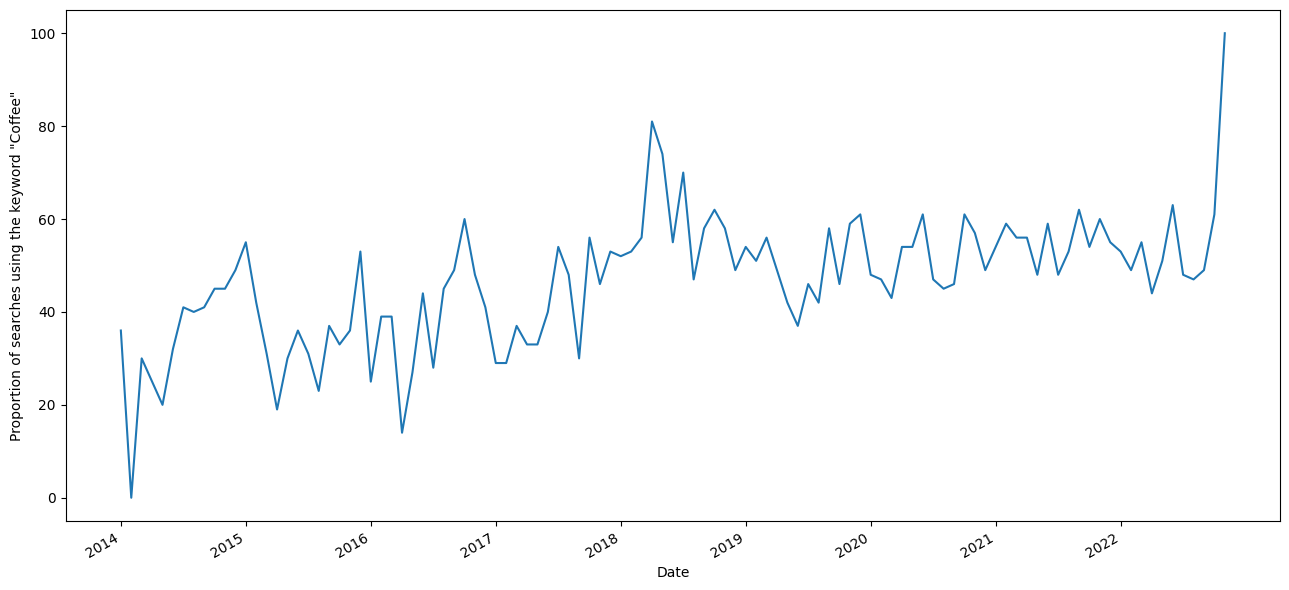

In [12]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df['Coffee'])
ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using the keyword "Coffee"')

plt.xticks(np.arange(0, 107, 12), np.arange(2014, 2023, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [13]:
df.columns = ['ds', 'y']

In [14]:
train = df[:-12]
# Keep the last 12 months for testing
test = df[-12:]  

# Hyperparameter Tuning & Cross Validation

In [19]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
    }

all_params = [dict(zip(param_grid.keys(), v)) for v in 
              product(*param_grid.values())]

cutoffs = pd.date_range(start='2019-01-31', end='2021-01-31', freq='12M')

mses = []

for param in all_params:
  m = Prophet(**param)
  m.add_country_holidays(country_name='NAM')
  m.fit(train)

  df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
  df_p = performance_metrics(df_cv, rolling_window=1)
  mses.append(df_p['mse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mse'] = mses

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/jlbrzf3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/ggk2xiej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14856', 'data', 'file=/tmp/tmpx9e16lqq/jlbrzf3f.json', 'init=/tmp/tmpx9e16lqq/ggk2xiej.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modelpat2pb87/prophet_model-20230611095811.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/fhmldfux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/iw40ykpv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39668', 'data', 'file=/tmp/tmpx9e16lqq/fhmldfux.json', 'init=/tmp/tmpx9e16lqq/iw40ykpv.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modelpqik_0ex/prophet_model-20230611095812.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/0z2n2ejh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/c96sk0ug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/yzd5d4bs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/mts7l_45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25363', 'data', 'file=/tmp/tmpx9e16lqq/yzd5d4bs.json', 'init=/tmp/tmpx9e16lqq/mts7l_45.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modelojwrjx_j/prophet_model-20230611095815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/a9jjvynx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/rdbwx85o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/p7nvzd97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/noqi4tfo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11724', 'data', 'file=/tmp/tmpx9e16lqq/p7nvzd97.json', 'init=/tmp/tmpx9e16lqq/noqi4tfo.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modeltd1q7rou/prophet_model-20230611095817.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/_ggo6j1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/s94zuwjk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/0h4p6qbc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/gw8wbl11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86167', 'data', 'file=/tmp/tmpx9e16lqq/0h4p6qbc.json', 'init=/tmp/tmpx9e16lqq/gw8wbl11.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modelyj7rp31_/prophet_model-20230611095820.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/k2or846f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/ue4ng3t3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/mekh6tjt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/rk3a12ih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23556', 'data', 'file=/tmp/tmpx9e16lqq/mekh6tjt.json', 'init=/tmp/tmpx9e16lqq/rk3a12ih.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_model4e9532gr/prophet_model-20230611095822.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/nhi_uo72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/x24cbiv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/um2wu3t7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/9f_4b2bh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93324', 'data', 'file=/tmp/tmpx9e16lqq/um2wu3t7.json', 'init=/tmp/tmpx9e16lqq/9f_4b2bh.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modelcqcgfq22/prophet_model-20230611095826.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/dtcdwv4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/jyr5wumr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/2zwpv0i2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/2etnghqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80224', 'data', 'file=/tmp/tmpx9e16lqq/2zwpv0i2.json', 'init=/tmp/tmpx9e16lqq/2etnghqm.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modelffvnkfpl/prophet_model-20230611095829.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/751lvo9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/vs53d8o7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/0g5fz8tn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/i7g1_4as.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58908', 'data', 'file=/tmp/tmpx9e16lqq/0g5fz8tn.json', 'init=/tmp/tmpx9e16lqq/i7g1_4as.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_model0fltxnak/prophet_model-20230611095831.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/0q5lvxea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/5h5dvlbe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/jej08kt_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/kjqbjnsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90216', 'data', 'file=/tmp/tmpx9e16lqq/jej08kt_.json', 'init=/tmp/tmpx9e16lqq/kjqbjnsg.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_model1_mke5d9/prophet_model-20230611095834.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/sp0nihvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/_x798i1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/vk2swmt_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/t4t94zu5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2621', 'data', 'file=/tmp/tmpx9e16lqq/vk2swmt_.json', 'init=/tmp/tmpx9e16lqq/t4t94zu5.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modeljxq8q926/prophet_model-20230611095838.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/ej0rgzm_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/p1ghon5m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/v0gp6e6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/9kc0t_z_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26340', 'data', 'file=/tmp/tmpx9e16lqq/v0gp6e6j.json', 'init=/tmp/tmpx9e16lqq/9kc0t_z_.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modelfjby1i5k/prophet_model-20230611095843.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/pk_12l2o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/ujotsxfs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/nrzj8cyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/91tfs72v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52745', 'data', 'file=/tmp/tmpx9e16lqq/nrzj8cyz.json', 'init=/tmp/tmpx9e16lqq/91tfs72v.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_model6vizii77/prophet_model-20230611095847.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/865nr1y_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/g_ko71hr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/r327jo_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/y71569g3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94651', 'data', 'file=/tmp/tmpx9e16lqq/r327jo_0.json', 'init=/tmp/tmpx9e16lqq/y71569g3.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_model2mpgtspy/prophet_model-20230611095853.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:58:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/i4ryl8qu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/r2tz66_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/zouy6y96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/nlz9_s57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69183', 'data', 'file=/tmp/tmpx9e16lqq/zouy6y96.json', 'init=/tmp/tmpx9e16lqq/nlz9_s57.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_model525yfrda/prophet_model-20230611095900.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:59:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:59:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/1zen_5u9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/ffjd8p9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/thvttda3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/8szcnbac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51186', 'data', 'file=/tmp/tmpx9e16lqq/thvttda3.json', 'init=/tmp/tmpx9e16lqq/8szcnbac.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modelsokrru5b/prophet_model-20230611095906.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:59:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:59:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/4jjucjtf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/70gswsjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/h4p2mf9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/wgksbmov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7133', 'data', 'file=/tmp/tmpx9e16lqq/h4p2mf9q.json', 'init=/tmp/tmpx9e16lqq/wgksbmov.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modelkgnwfxus/prophet_model-20230611095912.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:59:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:59:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/h7v2s6mz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/dpjs9gjl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

## Best Parameters from H-tuning

In [22]:
best_params = all_params[np.argmin(mses)]
(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}

In [23]:
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

In [29]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat',
                                                       'yhat_lower', 'yhat_upper']]

test['baseline'] = train['y'][-12:].values 

prophet_mae = mean_absolute_error(test['y'], test['y'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

## Plot

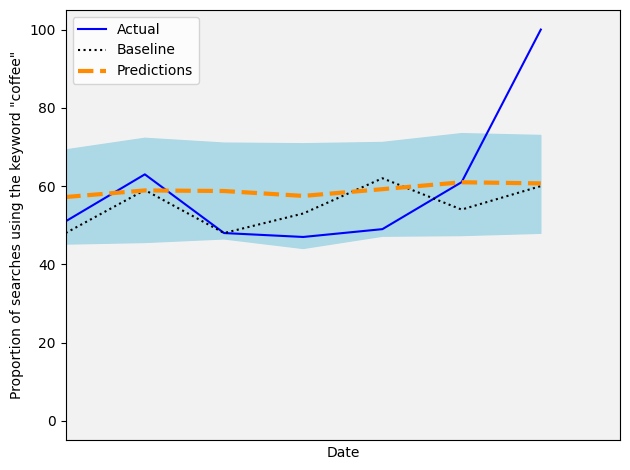

In [28]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['baseline'], 'k:', label='Baseline')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using the keyword "coffee"')

ax.axvspan(90, 107, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 107, 12), np.arange(2014, 2023, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'],
                 y2=test['yhat_upper'], color='lightblue')
plt.xlim(100, 107)

fig.autofmt_xdate()
plt.tight_layout()

In [21]:
m = Prophet(**best_params)
m.add_country_holidays(country_name="NAM")
m.fit(train);

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/524tn_5f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx9e16lqq/ah0v038m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12417', 'data', 'file=/tmp/tmpx9e16lqq/524tn_5f.json', 'init=/tmp/tmpx9e16lqq/ah0v038m.json', 'output', 'file=/tmp/tmpx9e16lqq/prophet_modeljso0954l/prophet_model-20230611100432.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:04:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:04:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


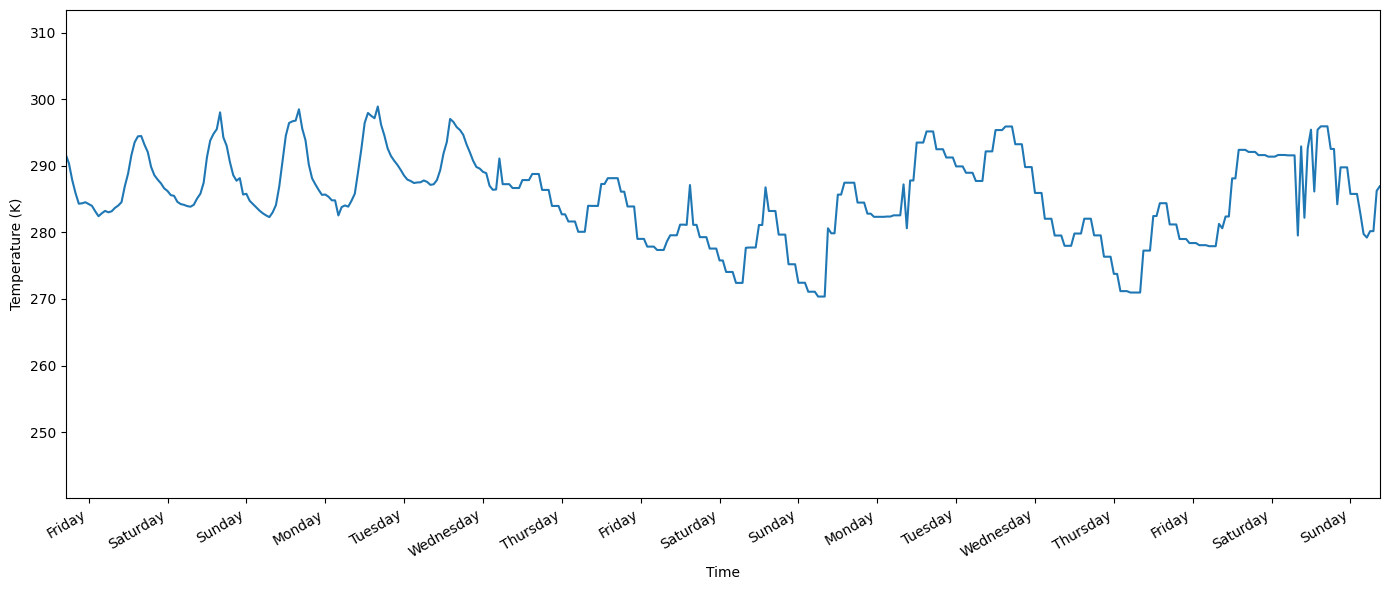

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 
                                   'Tuesday', 'Wednesday', 'Thursday', 
                                   'Friday', 'Saturday', 'Sunday', 'Monday', 
                                   'Tuesday', 'Wednesday', 'Thursday', 
                                   'Friday', 'Saturday', 'Sunday' ])
plt.xlim(0, 400)
fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,17551.000000,17551.000000,17551.0,17551.000000,17551.000000
mean,281.416203,0.025523,0.0,42.034129,3321.484588
std,12.688262,0.259794,0.0,39.065960,1969.223949
min,243.390000,0.000000,0.0,0.000000,113.000000
25%,272.220000,0.000000,0.0,1.000000,1298.000000
50%,282.410000,0.000000,0.0,40.000000,3518.000000
75%,291.890000,0.000000,0.0,90.000000,4943.000000
max,310.070000,10.600000,0.0,100.000000,7280.000000


In [ ]:
# Drop columns which are mostly naught throughout data (see Peixeiro 2022, pg 242)
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

In [ ]:
# Convert date_time from string to a numerical value of seconds (see Peixeiro 2022, pg 242)
# Retain cyclical nature of time by way of the sin transformation
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)
day = 24 * 60 * 60 # Number of seconds in a day
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values # Radians are used in the sine function

While the sin transformation regains the syclical property of time, it leaves indistinguished the difference between am and pm. We correct this by applying a cosine transformation—it being out of phase with the sine function—allowing thus the distinction between am and pm time. 

In [ ]:
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
df = df.drop(['date_time'], axis=1)

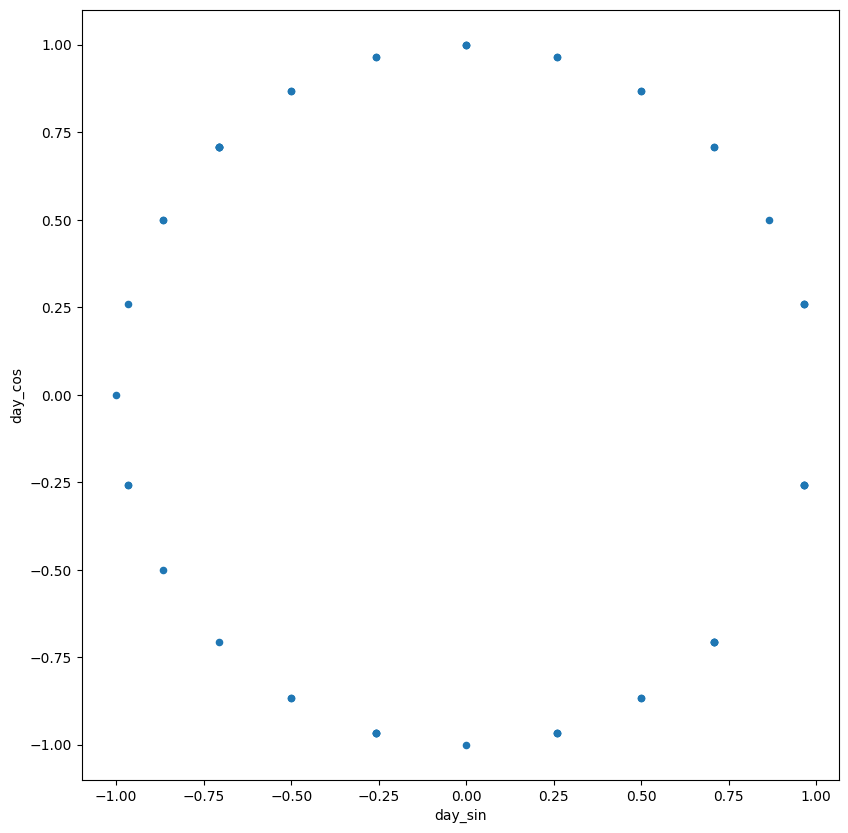

In [ ]:
# Confirm sine vs cosine function
df.sample(50).plot.scatter('day_sin', 'day_cos', figsize=(14, 10)).set_aspect('equal')

The above plot confims that we have converted the time strings to numerical values that retain the cyclical nature of time, a format conducive for deep learning models. 

In [ ]:
n = len(df)

# Split the data by train, validation, and test ration of 70:20:10
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]